In [99]:
import pandas as pd
import numpy as np

path_to_train_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\train.csv"
path_to_test_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\test.csv"
train_data = pd.read_csv(path_to_train_data)
test_data = pd.read_csv(path_to_test_data)

# Inspect the raw data

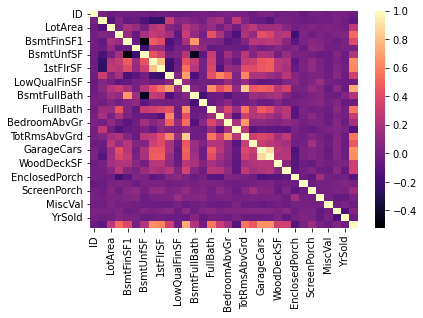

In [100]:
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from termcolor import colored as cl # text customization

sb.heatmap(train_data.corr(), cmap = 'magma')
plt.savefig('heatmap.png', format='png')
plt.show()

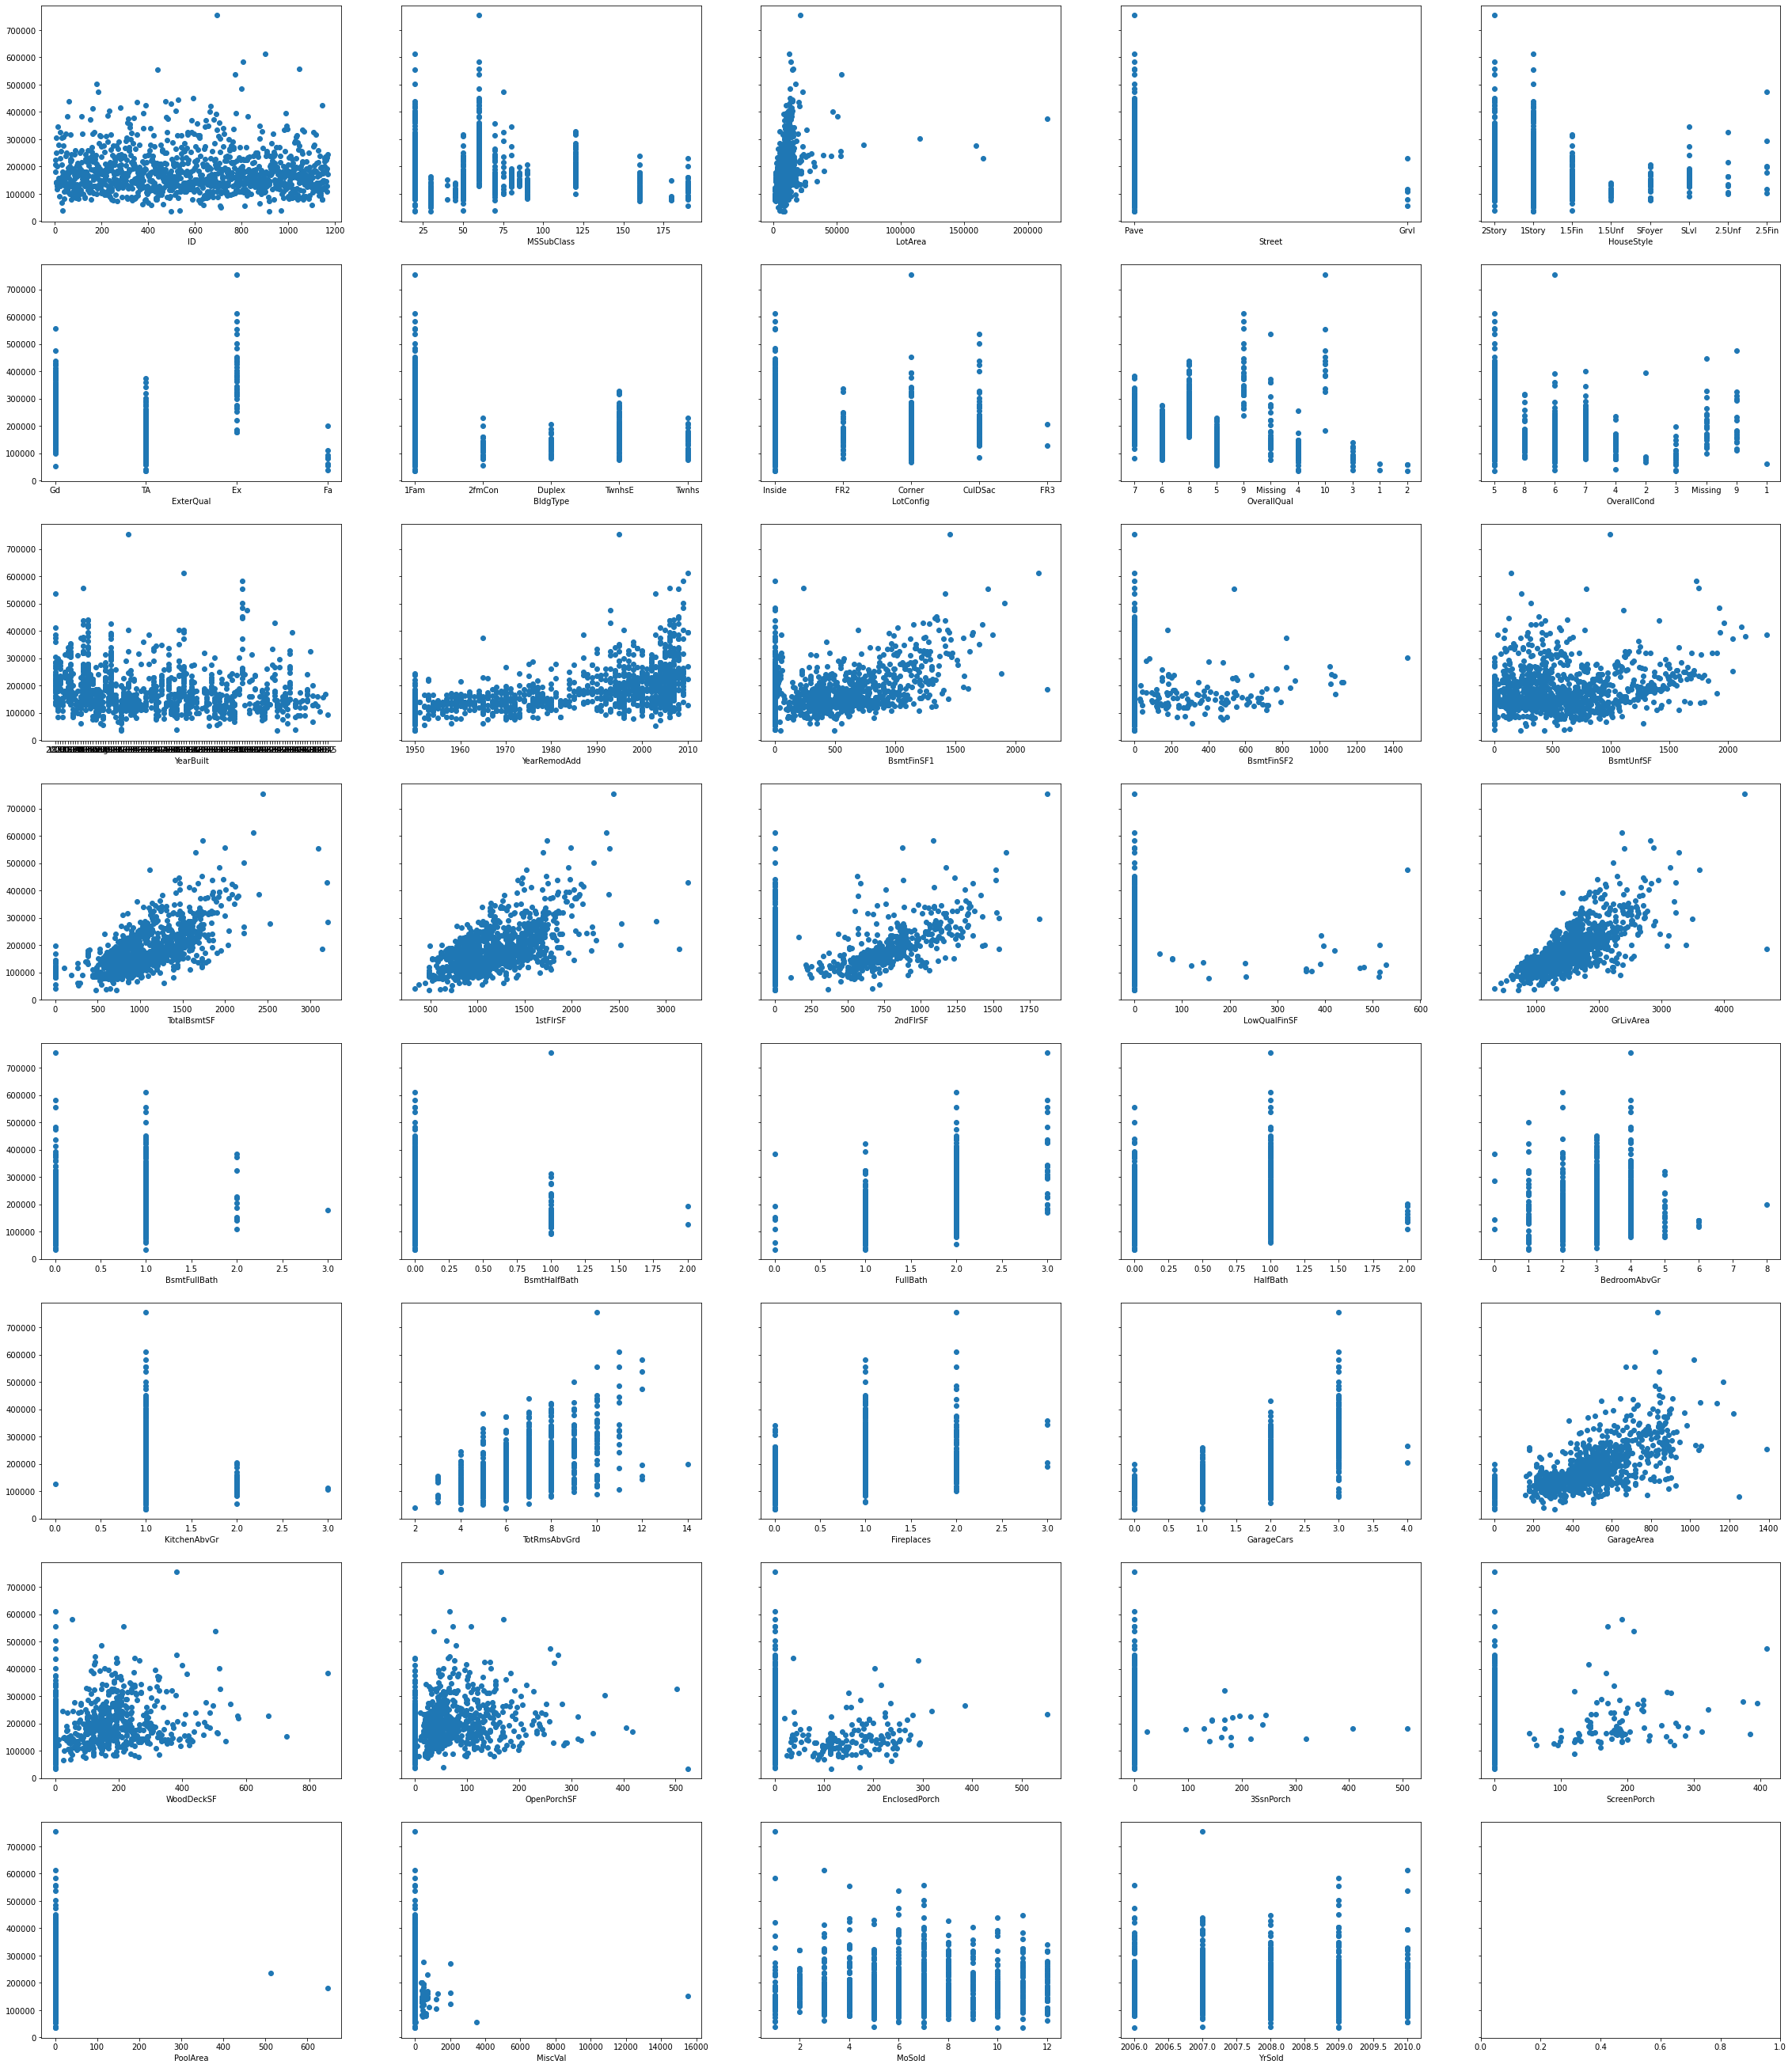

<Figure size 432x288 with 0 Axes>

In [101]:
# Plot independent variable (sales price) vs. each dependent variable

import matplotlib.pyplot as plt
import math

def plot_custom_subplot(df_obj, y_series, num_cols=int(5)):
    num_plots = len(df_obj.columns)
    num_rows = math.ceil(num_plots/num_cols)
    fig, ax_array =  plt.subplots(num_rows, num_cols, figsize=(100/2.54, 120/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        for axes in ax_row:
            axes.set_xlabel(df_obj.columns[k])
            axes.scatter(df_obj.iloc[:, k], y_series)
            k += 1
            if k == num_plots:
                break
    
    plt.show()    
    plt.savefig('scatter_raw_train_data.png', format='png')

plot_custom_subplot(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

# Process the raw data

In [102]:
def get_cols_with_missing(dfObj, value:"Missing") -> list:
    """Return list of the columns that equal the value."""
    
    listCols = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listCols.append(col)

    unique_cols = np.unique(listCols)
    return unique_cols

train_cols_with_missing = get_cols_with_missing(train_data, "Missing")
print(train_cols_with_missing)

test_cols_with_missing = get_cols_with_missing(test_data, "Missing")
print(test_cols_with_missing)

['OverallCond' 'OverallQual' 'YearBuilt']
['OverallCond' 'OverallQual' 'YearBuilt']


In [103]:
def replace_missing_with_mean(df_object, cols_with_missing:list):
    """Replace the fields in the dataframe object with the mean of that column."""

    df_object.replace(to_replace="Missing", value=np.nan, inplace=True)

    # df_object['OverallQual'].mean() didnt' work because data type not number. Write it up in the report.
    # df_object['OverallQual'].dtypes #dtype('O') is a string

    for col in cols_with_missing:
        df_object[col] = df_object[col].astype('float') # because NaN is a float and mean() requires same data type
        df_object[col].fillna(value=df_object[col].mean(), inplace=True) 
        df_object[col] = df_object[col].astype('int') # linear regression only supports int type

# replace_missing_with_mean(test_data, cols_with_missing)

In [104]:
def get_rows_with_missing_data(df_object, cols_with_missing:list):
    """Find row if it contains 'Missing' in any of the columns in cols_with_missing."""

    rows_with_missing = []
    for index, row in df_object.iterrows():
        # If the row contains at least one 'Missing' then append to the list
        num_missing = 0
        for col in cols_with_missing:
            if row[col] == 'Missing':
                num_missing += 1
        if num_missing > 0:
            rows_with_missing.append(row)

    return rows_with_missing

train_rows_with_missing = get_rows_with_missing_data(train_data, train_cols_with_missing)
test_rows_with_missing = get_rows_with_missing_data(test_data, test_cols_with_missing)

print(f'Train.csv has {len(train_rows_with_missing)} rows with \'Missing\' data out of {len(train_data)}.')
print(f'Test.csv has {len(test_rows_with_missing)} rows with \'Missing\' data out of {len(test_data)}.')



Train.csv has 66 rows with 'Missing' data out of 1168.
Test.csv has 15 rows with 'Missing' data out of 292.


In [105]:
#TODO: why isn't drop_rows killing it off?
def drop_rows(df):
    """Drops rows if the columns OverallCond, OverallQual of YearBuilt contain 'Missing'."""
    df_subset = df[(df['OverallCond'] != 'Missing') & (df['OverallQual'] != 'Missing') & (df['YearBuilt'] !='Missing')] 
    return df_subset

df_new = drop_rows(train_data)

# Additional cleaning operations

In [106]:
# Find the columns with 'object' datatypes
def get_categoricals(dataframe) -> list:
    categoricals = []
    for col in dataframe.columns:
        if dataframe[col].dtypes == "object":
            categoricals.append(col)
    return categoricals

# categoricals = get_categoricals(test_data)
# print(categoricals)

In [107]:
# Apply one hot encoding to categoricals.
# Source: https://medium.com/jungletronics/pandas-one-hot-encoding-ohe-eb7467dc92e8

def one_hot_encode(dataframe, categoricals:list):
    """Mutates dataframe by dropping categoricals and concatenating one hot encoding."""

    for idx, category in enumerate(categoricals):
        # print(f'index: {idx} \n')
        variables_list = dataframe[category].unique()
        print(f'category: {category}: {variables_list}')
        if len(variables_list) == 2:
            set_arg = True # set drop_first true because categories are binary
        else:
            set_arg = False

        dummy1 = pd.get_dummies(dataframe[category], drop_first=set_arg)
        dataframe = pd.concat([dataframe, dummy1], axis=1).drop(category, axis=1)
    return dataframe

# test_data = one_hot_encode(test_data, categoricals + ['MSSubClass'])


In [108]:
# Finally, convert all data types to integer for regression model
def convert_dtype_int(df_object):
    for name, data_series in df_object.iteritems():
        df_object[name] = df_object[name].astype(int) # print(scatter_df.dtypes)

# convert_dtype_int(test_data)

In [109]:
# Normalise the data
# data = normalise_data(data) # normalising not required for linear regression, the coefficients don't change.
# https://stats.stackexchange.com/questions/189652/is-it-a-good-practice-to-always-scale-normalize-data-for-machine-learning

from sklearn.preprocessing import MinMaxScaler

def normalise_data(df):
    scaler = MinMaxScaler(feature_range = (0, 1)) # range is [0, 1]
    normed = scaler.fit_transform(df.copy())
    df = pd.DataFrame(data=normed, columns=df.columns)
    return df

In [110]:
def split_train_test(df):
    X = df.drop(['SalePrice'], axis=1)
    y = df['SalePrice']
    return X, y

In [111]:
def prepare_data(data, missing_data_treatment):
    # Process 'Missing' data
    if missing_data_treatment =='mean':
        cols_with_missing = get_cols_with_missing(data, "Missing")
        replace_missing_with_mean(data, cols_with_missing)
    if missing_data_treatment =='drop':
        data = drop_rows(data)

    # Process categoricals
    categoricals = get_categoricals(data)
    data = one_hot_encode(data, categoricals)

    # Convert to integer data type
    convert_dtype_int(data)
    
    # Split into training and test set
    X, y = split_train_test(data)

    return X, y

In [112]:
# X_train, y_train = prepare_data(train_data, missing_data_treatment='mean')
# X_test, y_test = prepare_data(test_data, missing_data_treatment='mean')

# Comment: train_data has one more MSSubClass than testData

In [113]:
# # Figure out what to do about X_train
# set_a = { 70,  60,  80,  20, 160,  50, 120,  30, 190,  75,  85,  90,  40, 180} # from test
# set_b = { 60, 20,  70, 50, 190,  45,  90, 120,  30,  85,  80, 160,  75, 180,  40} # from train

# result = set_a.symmetric_difference(set_b) 
# print(result) # 45

In [114]:
# X_train = X_train.drop([45], axis=1)

In [115]:
# Do Linear regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

from sklearn import linear_model
from sklearn import compose
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

def run_lin_regression(X_train, y_train, X_test, y_test, wrapped=False):
    # Create linear regression object (Ordinary Least Squares)
    models = dict(
        ols=linear_model.LinearRegression(), 
        ridge=linear_model.Ridge(alpha=0.1),
        huber= linear_model.HuberRegressor(max_iter=10000),
        ransac =linear_model.RANSACRegressor(random_state=0),
        theil_sen= linear_model.TheilSenRegressor()
    )

    for name, model in models.items():
        print(f'\nRunning {name} regression.')
        if wrapped == True:
            pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', HuberRegressor())])
            wrapped_model = compose.TransformedTargetRegressor(regressor=model, transformer=MinMaxScaler())
            wrapped_model.fit(X_train, y_train)
            y_predicted = wrapped_model.predict(X_test)
        else:
            # Train the model using the training sets
            model.fit(X_train, y_train)
            # Make predictions using the testing set
            y_predicted = model.predict(X_test)

        # The coefficients
        # print("Coefficients: \n", reg.coef_)
        # The mean squared error
        print("Mean squared error: %.10f" % mean_squared_error(y_test, y_predicted))
        # The coefficient of determination: 1 is perfect prediction
        print("Coefficient of determination: %.10f" % r2_score(y_test, y_predicted))


In [116]:
X_train, y_train = prepare_data(train_data, missing_data_treatment='drop')
X_test, y_test = prepare_data(test_data, missing_data_treatment='drop')
# run_lin_regression(X_train, y_train, X_test, y_test)

category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: OverallQual: ['7' '6' '8' '5' '9' '4' '10' '3' '1' '2']
category: OverallCond: ['5' '8' '6' '7' '4' '2' '3' '9' '1']
category: YearBuilt: ['2003' '1976' '2001' '1915' '2000' '1993' '2004' '1973' '1931' '1939'
 '1965' '2005' '1962' '1960' '1970' '1967' '1958' '1930' '2002' '1968'
 '2007' '1951' '1957' '1927' '1920' '1966' '1959' '1994' '1954' '1953'
 '1955' '1983' '1975' '1934' '1963' '1981' '1964' '1999' '2006' '1972'
 '1921' '1997' '1945' '1998' '1956' '1948' '1910' '1995' '1991' '2009'
 '1950' '1961' '1977' '1985' '1979' '1885' '1919' '1990' '1969' '1935'
 '1988' '1971' '1952' '1936' '1923' '1924' '1984' '1926' '1940' '1941'
 '1987' '1986' '2008' '1908' '1892' '1916' '1932' '1918' 

# Task 1 
Apply two techniques to handle missing data
Justify why these two techniques were chosen
compare the regression model's performance on the two data sets

TEchnique 1: drop the missing valus
technique 2: fill the missing values if you know them. No I don't
Technique 3: fill missing values with the mean of that column

# Task 2
 Write Python code to build a regression model from the training set that you applied the better
solution in (1). Write the code to evaluate its performance on the test set that you applied the better
solution in (1) with Root-Mean-Squared-Error (RMSE). RMSE shares similar motivation of the least
square loss we taught in the lecture. Section 5 gives reference for the definition. Please try at least
two regression models and compare their performances.  

# Task 3
There are 38 features provided for each house. Are all of the features used in your regression
models? What’s the impact if removing some features? Please write your own code to compare
different feature selections and justify your selection. At least two feature selections are investigated
(full feature set, a subset of the features). The dataset is the modified ones that you applied the
better solution in (1). (6 Marks)

In [117]:
# drop ID because it contains no information about the house
# drop MSsubclass because the that information is repeated in the categoricals anyway with more fidelity
# drop MoSold - assume no seasonal price trends
# drop MiscVal - seems immaterial
# drop Fireplaces - seems incidental to the house sale


# query is sale price adjusted for inflation?

columns_to_drop = ['ID', 'MSSubClass', 'MoSold', 'MiscVal', 'Fireplaces']

def create_data_subset(X_train, X_test, columns_to_drop):
    X_train_subset = X_train.copy()
    X_test_subset = X_test.copy()

    for column in columns_to_drop:
        X_train_subset = X_train_subset.drop([column], axis=1)
        X_test_subset = X_test_subset.drop([column], axis=1)
    return X_train_subset, X_test_subset

X_train_subset, X_test_subset = create_data_subset(X_train, X_test, columns_to_drop)

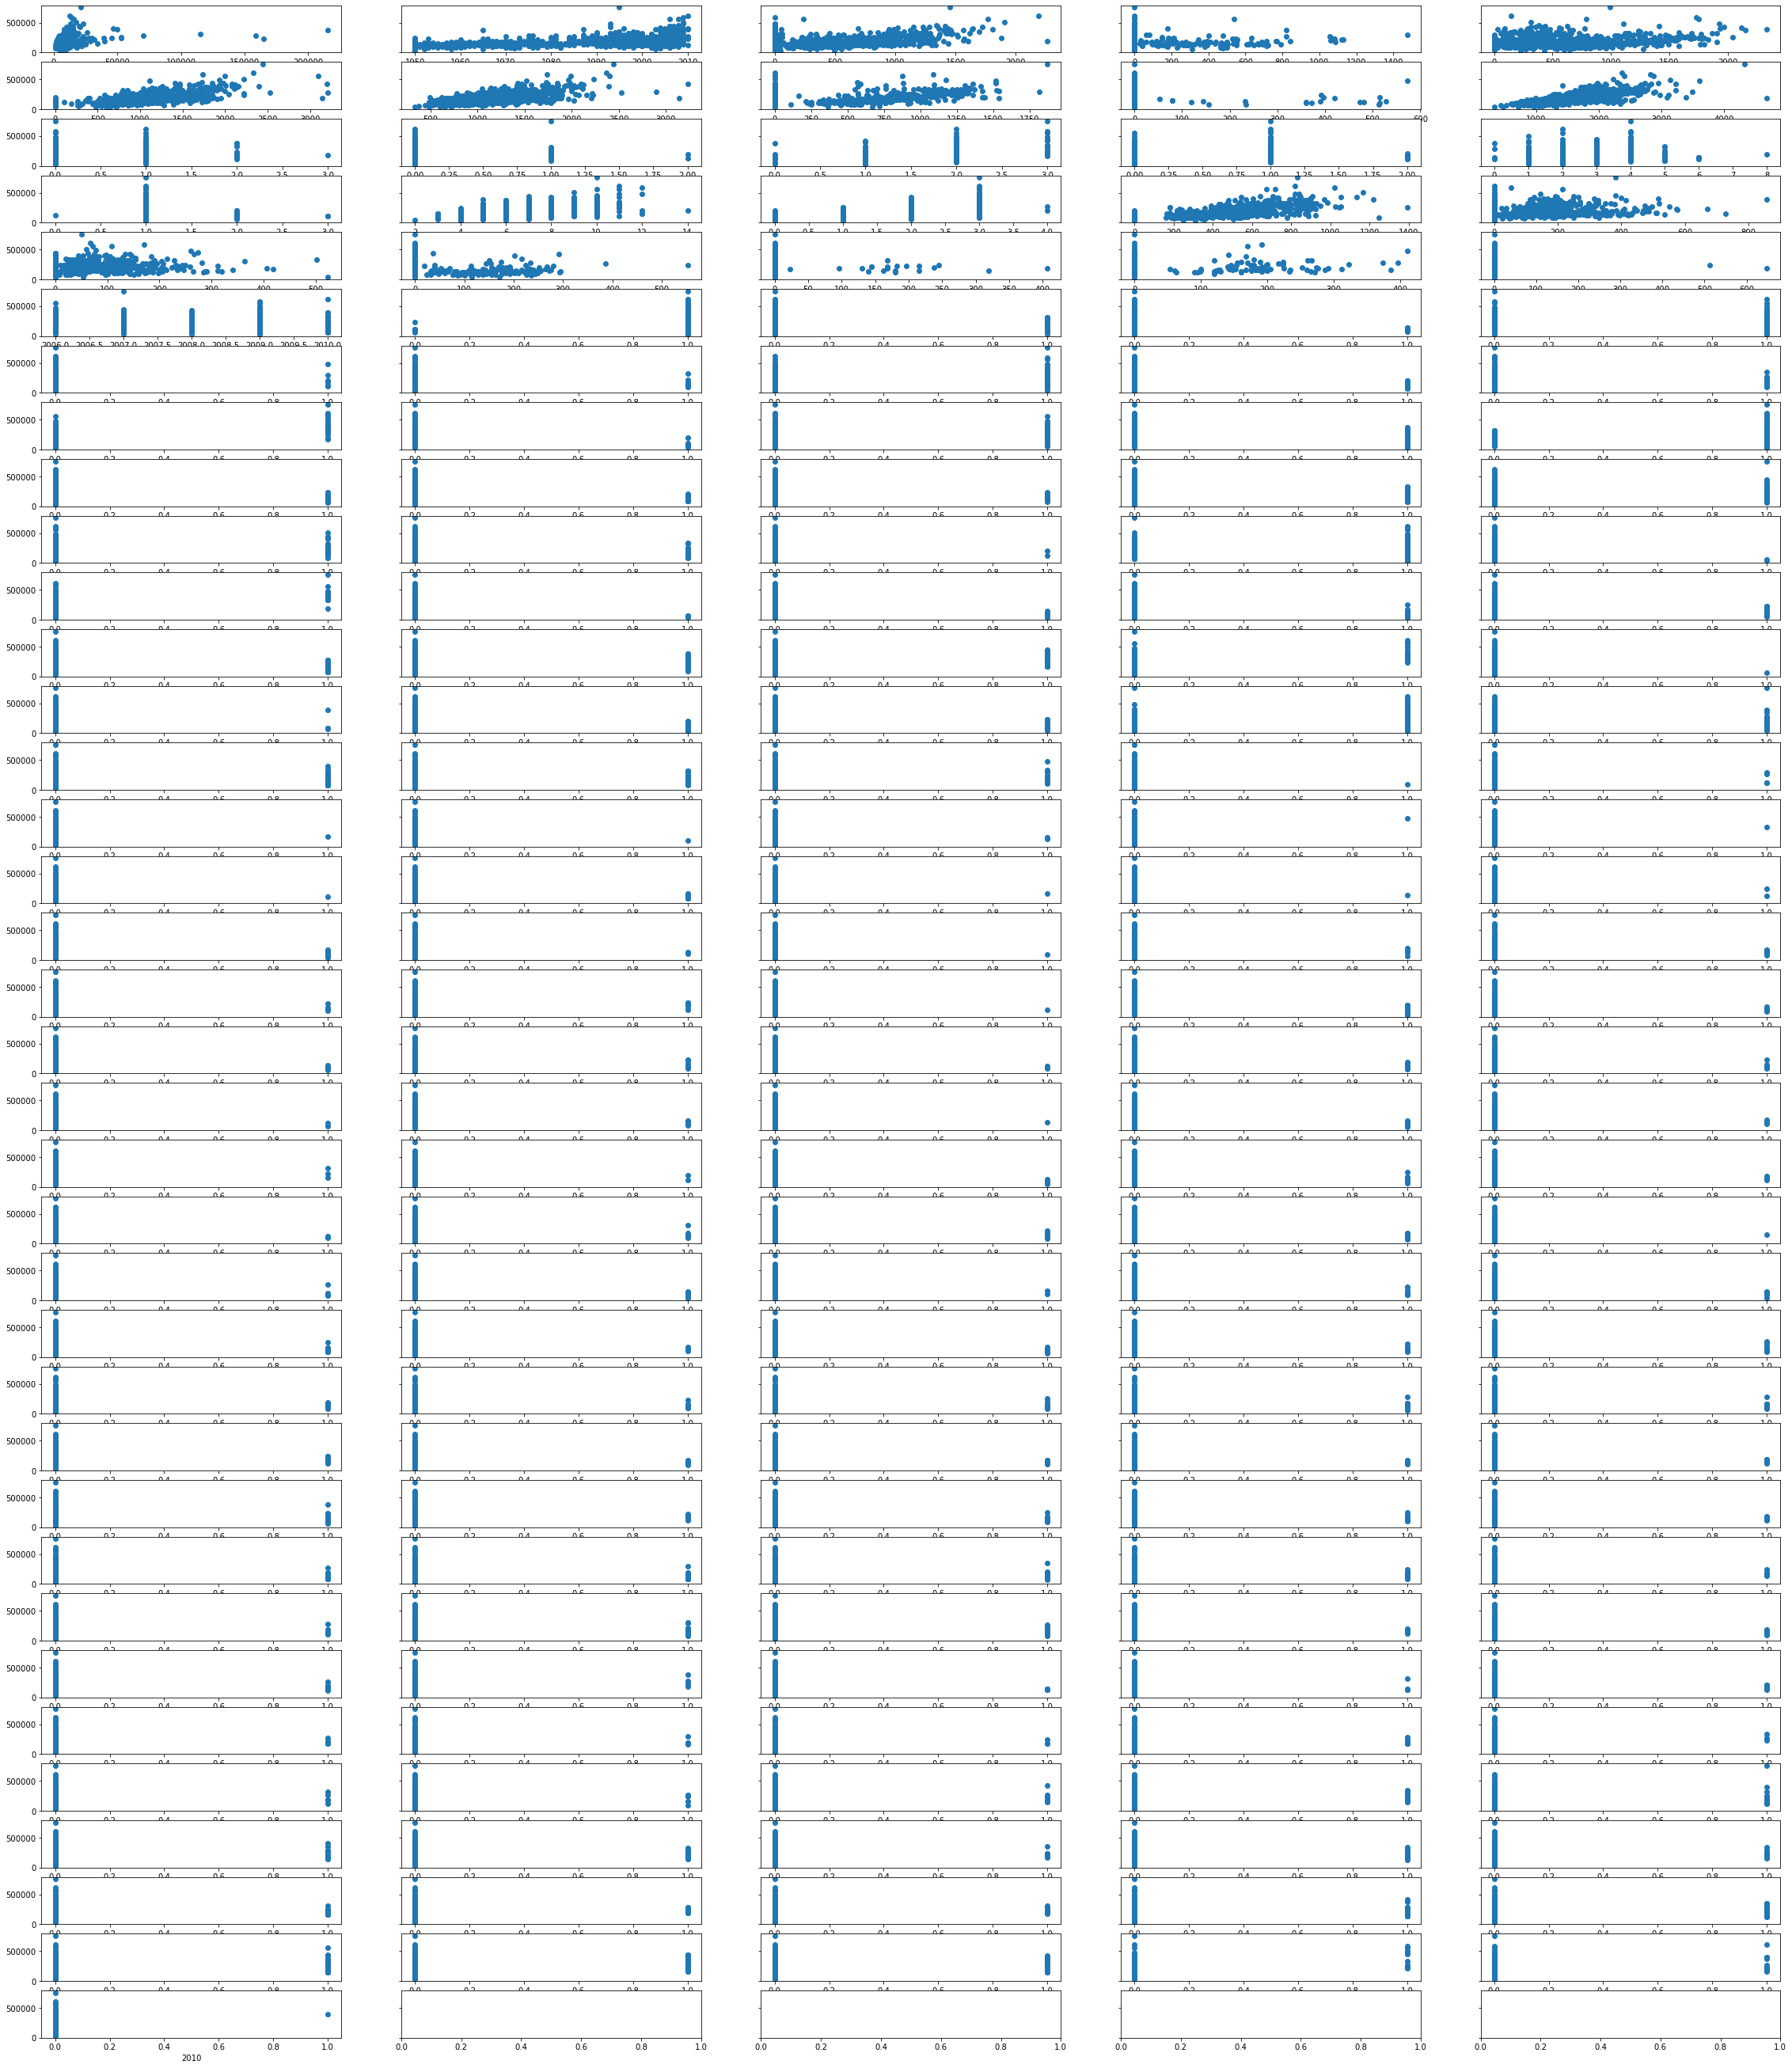

<Figure size 432x288 with 0 Axes>

In [118]:
plot_custom_subplot(X_train_subset, y_train)

<AxesSubplot:>

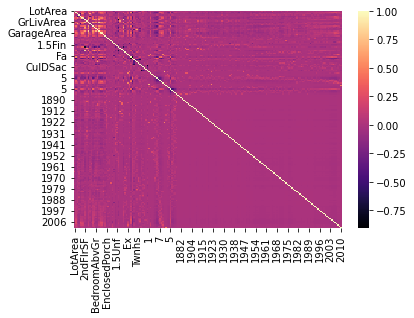

In [119]:
sb.heatmap(X_train_subset.corr(), cmap = 'magma')

In [120]:
run_lin_regression(X_train_subset, y_train, X_test_subset, y_test)


Running ols regression.


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 176 is different from 152)

v

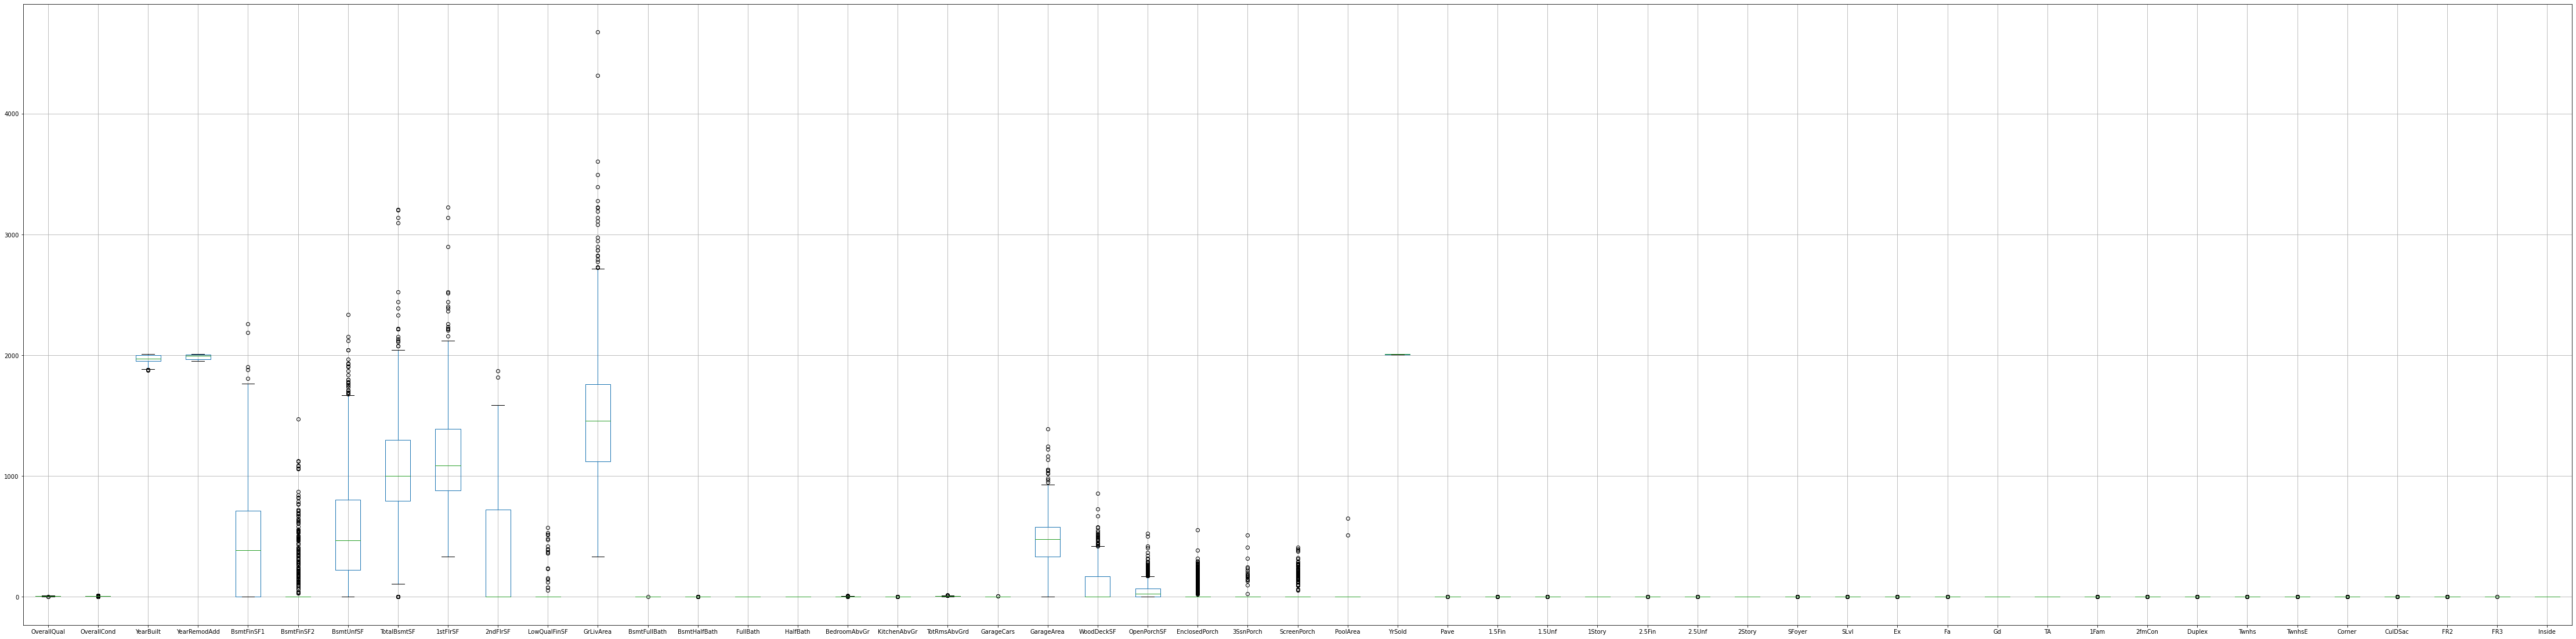

In [ ]:
# Evaluate the difference between normalisation vs. standardisation
# https://www.baeldung.com/cs/normalization-vs-standardization

from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler().fit(X_train_subset)
# X_std = scaler.transform(X)

boxplot = X_train_subset.drop(["LotArea"], axis=1).boxplot(figsize=(200/2.54, 50/2.54))

(-20.0, 20.0)

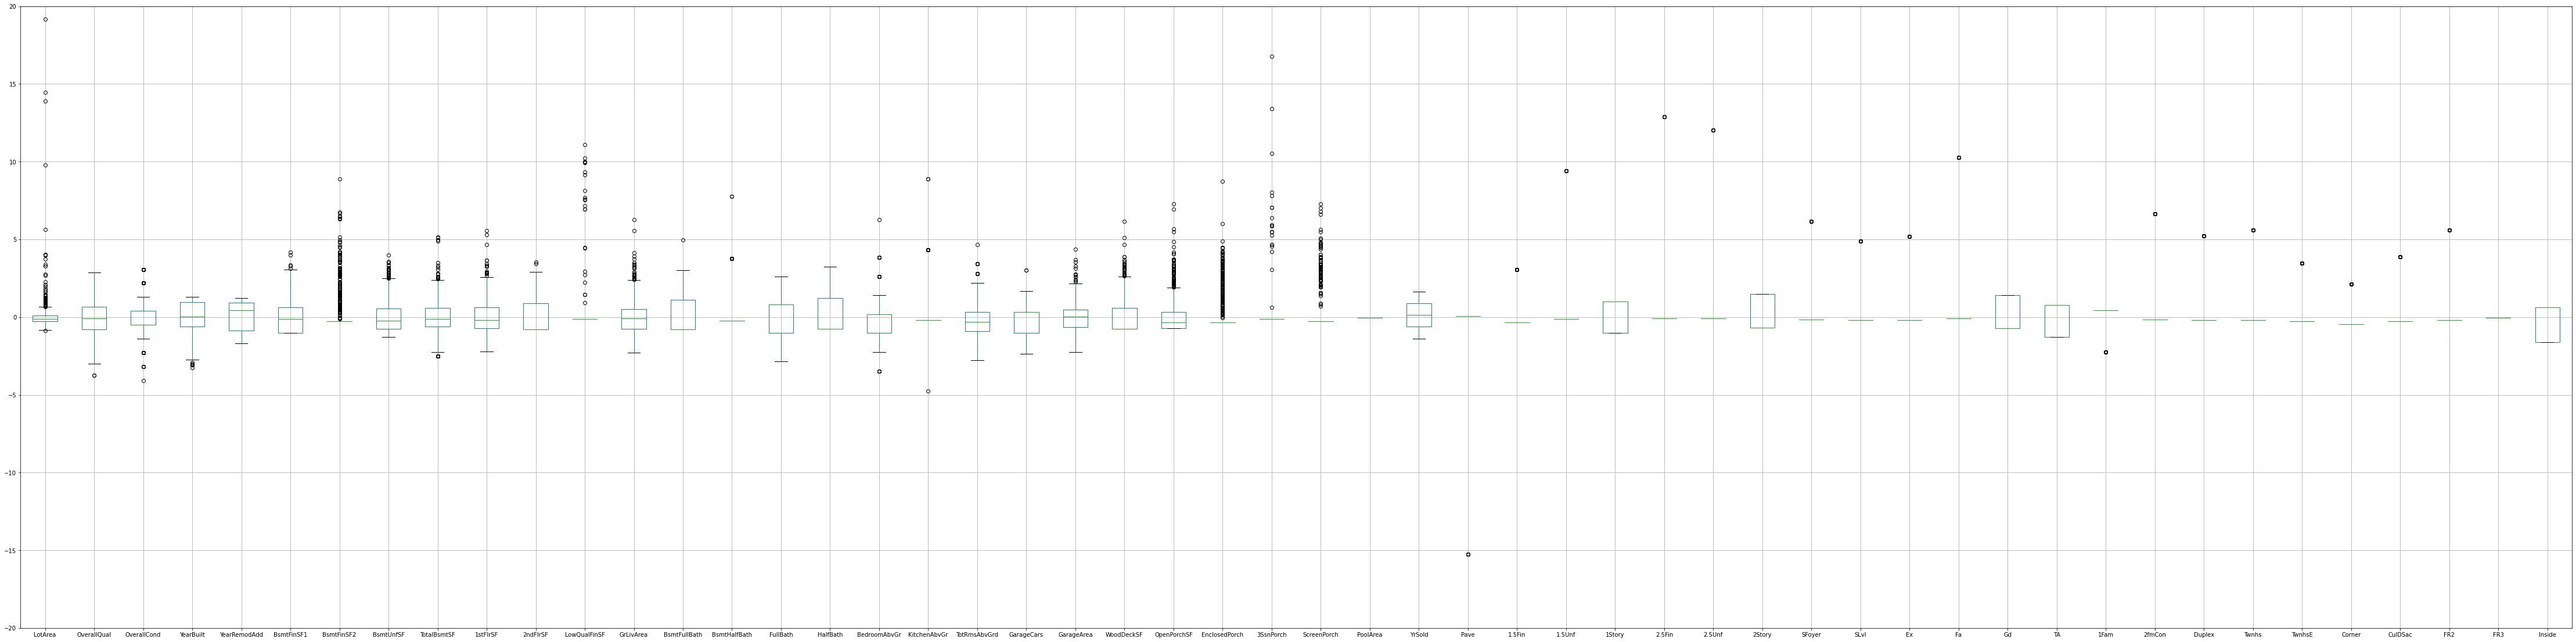

In [ ]:
# Scale features

X_train_subset_scaled = StandardScaler().fit_transform(X_train_subset)
X_test_subset_scaled = StandardScaler().fit_transform(X_test_subset)

# X_train_subset_scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(X_train_subset)
# With args, the boxplot shows mean not equal to zero. All values are positive. Why?

df = pd.DataFrame(X_train_subset_scaled, columns = X_train_subset.columns)
boxplot = df.boxplot(figsize=(200/2.54, 50/2.54))
plt.ylim(-20,20)

In [ ]:
run_lin_regression(X_train_subset, y_train, X_test_subset, y_test, wrapped=True)

# https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/
# wrapped_model = TransformedTargetRegressor(regressor=model, transformer=MinMaxScaler())


Running ols regression.


NameError: name 'HuberRegressor' is not defined

In [ ]:
train_data['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1163    108959
1164    194000
1165    233170
1166    245350
1167    173000
Name: SalePrice, Length: 1168, dtype: int64

In [ ]:
# Naively calling a regression function with raw data
# run_lin_regression(train_data.drop(['SalePrice'], axis=1), train_data['SalePrice'], test_data.drop(['SalePrice'], axis=1), test_data['SalePrice'])



Running ols regression.


ValueError: could not convert string to float: 'Pave'